### Flow data discretization task

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Pre-process data and create new columns to have a better overview

### remove background data

In [2]:
names = ['date', 'time', 'protocol_num', 'protocol', 'src', 'direction', 'dst', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label']
df = pd.read_csv('data/capture20110818_51_.pcap.netflow.labeled',skiprows=1,header=0,sep='\s+',names=names)

## remove background data
df = df[df['label'] != 'Background']

In [3]:
# load data
# split ip:port columns
df['src_ip'], df['src_port'] = df['src'].str.split(':', 1).str
df['dst_ip'], df['dst_port'] = df['dst'].str.split(':', 1).str
df['src_ip_num'] = pd.Categorical(df['src_ip'], categories=df['src_ip'].unique()).codes
df['dst_ip_num'] = pd.Categorical(df['dst_ip'], categories=df['dst_ip'].unique()).codes

# convert categorical data
df['protocol_num'] = pd.Categorical(df['protocol'], categories=df['protocol'].unique()).codes

# merge date and time columns
df['date_time'] = pd.to_datetime(df[['date', 'time']].apply(lambda x: ' '.join(x), axis=1))


### Now we have to collect data on infected vs normal

In [4]:
infected_ip = '147.32.84.165'
normal_ips  = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

infected = df[df['src_ip'] == infected_ip]
normal = df[df['src_ip'].isin(normal_ips)]

In [5]:
def stats(feat):
    print("infected", np.mean(infected[feat]), np.std(infected[feat]))
    print("normal", np.mean(normal[feat]), np.std(normal[feat]))
    print()

feat = 'packets'
print(feat)
stats(feat)

feat = 'bytes'
print(feat)
stats(feat)

feat = 'dst_ip_num'
print(feat)
stats(feat)

feat = 'protocol_num'
print(feat)
stats(feat)

feat = 'flows'
print(feat)
stats(feat)

feat = 'tos'
print(feat)
stats(feat)

feat = 'protocol_num'
print(feat)
stats(feat)

feat = 'flags'
print(feat)
print(infected[feat].unique())
print(normal[feat].unique())
print(np.intersect1d(infected[feat].unique(), normal[feat].unique()))

packets
infected 15.838704811704963 102.14974396846016
normal 11.064596117720725 119.77622031606509

bytes
infected 14104.12494343607 84289.07804858816
normal 8127.968991859737 123680.56803508165

dst_ip_num
infected 405.81396751973455 24.744904651069245
normal 106.71509079524108 168.09701466960666

protocol_num
infected 1.941676303484338 0.30991983607651935
normal 0.28065122103944895 0.4874454661662016

flows
infected 1.0 0.0
normal 1.0 0.0

tos
infected 0.0 0.0
normal 0.0 0.0

protocol_num
infected 1.941676303484338 0.30991983607651935
normal 0.28065122103944895 0.4874454661662016

flags
['INT' 'SRPA_' 'RA_' 'SPA_' 'A_' 'PA_' 'SA_' 'UNK' 'TST' 'SEC' 'ROB' 'RTS'
 'MAS' 'ECO' 'RED' 'IRQ' 'TXD' 'DNQ' 'RTA' 'AHA' '___' 'MHR' 'MRP' 'MRQ'
 'PTB' 'WAY' 'NNA' 'PHO' 'IAH' 'TRC' 'NNS' 'NRS' 'NRA' 'SKP' 'PAR' 'SRC'
 'UR' 'DNP' 'DCE' 'URHU']
['A_' 'FA_' 'PA_' 'INT' 'FSA_' '_FSA' 'FSPA_' '_FSPA' 'SPA_' 'FPA_' 'RA_'
 'SA_' 'R_' 'FSRPA_' 'FRA_' '_FSRA' 'URP' 'RPA_' 'SRPA_' 'FRPA_' 'S_'
 'ECO' 'ECR'

### as features we select protocol_num and bytes, because they both varied the most between normal and infected

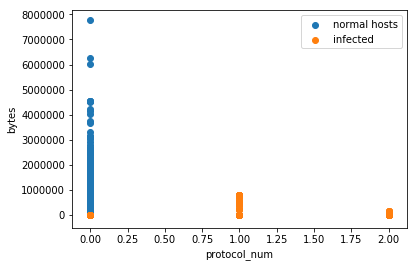

In [6]:
feat1 = 'protocol_num'
feat2 = 'bytes'
figure = plt.figure()
plt.scatter(normal[feat1], normal[feat2], label='normal hosts')
plt.scatter(infected[feat1], infected[feat2], label='infected')
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.legend()
plt.show()
figure.savefig('features.png')

### Now we have to create the function for discretization

In [7]:
class M_num:
    '''
    Compute the mapping for numerical features
    '''
    
    # paramater to change number of percentiles
    p = 5
    
    # percentile vals contains the feature values corresponding to the different percentiles
    percentile_vals = []
    # s is the size of the feature (i.e. |M_i|)
    s = 0
    # feature that we're working with
    feat = ''
    # the full dataframe
    df = None

    def __init__(self, df, feat):
        percentiles = np.arange(.1,1,1 / self.p)
        self.percentile_vals = map(lambda p: np.percentile(df[feat],p), percentiles)
        self.s = len(percentiles)
        self.feat = feat
        self.df = df

    # return the size |M_i|
    def size(self):
        return self.s

    # return the value M_i
    def val(self, row):
        val = row[self.feat]
        prev = 0
        for i,cur in enumerate(self.percentile_vals):
            if val >= prev and val < cur:
                return i
            prev = cur
        return 0

class M_cat:
    '''
    Compute the mapping for categorical features
    '''
    
    # s is the size of the feature (i.e. |M_i|)
    s = 0
    # feature that we're working with
    feat = ''
    # the full dataframe
    df = None

    def __init__(self, df, feat):
        self.s = len(df[feat].unique())
        self.feat = feat
        self.df = df

    # return the size |M_i|
    def size(self):
        return self.s
    
    # return the value M_i
    def val(self, row):
        return row[self.feat]

# encode a single record 
def encode_flow(feats, row):
    code = 0
    space_size = 1
    for feat in feats:
        space_size *= feats[feat].size()
    for feat in feats:
        s = feats[feat].size()
        v = feats[feat].val(row)
        code += v * (space_size / s)
        space_size = space_size / s
    return code

# encode an entire series of records
def encode_series(df, feats):
    encoded = []
    for index, row in df.iterrows():
        encoded.append(encode_flow(feats, row))
    return encoded

### and the plot

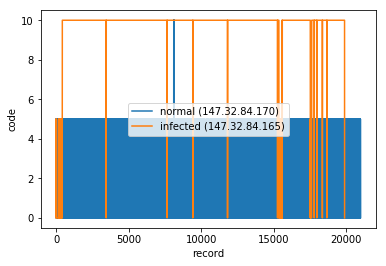

In [8]:

# compare one normal host with the infected host
normal_one_host = normal[normal['src_ip'] == normal_ips[0]]
figure = plt.figure()
feats = {'protocol_num': M_cat(normal_one_host, 'protocol_num'), 'bytes': M_num(normal_one_host, 'bytes')}
plt.plot(encode_series(normal_one_host, feats), label='normal ({})'.format(normal_ips[0]))
feats = {'protocol_num': M_cat(infected, 'protocol_num'), 'bytes': M_num(infected, 'bytes')}
plt.plot(encode_series(infected, feats), label='infected (147.32.84.165)')
plt.xlabel('record')
plt.ylabel('code')
plt.legend()
plt.show()
figure.savefig('disretization_figure.png')